### Import Modules and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
df_ger = pd.read_csv("data/preprocessed_survey_results_encoded.csv")

### Helper Functions


In [3]:
def calc_scores(estimators, x_test, y_test) -> (list, list, list, list, list):
    """
    Calculates the scores from multiple estimators. For example of cross validations.

    :param estimators: list of estimators
    :param x_test: x test split
    :param y_test: y test split
    :return: quadruple of list of the scores
    """
    r2_scores = []
    mae_scores =  []
    mape_scores = []
    rmse_scores = []
    max_scores = []
    for estimator in estimators:
        predictions = estimator.predict(x_test)
        r2_scores.append(metrics.r2_score(y_test, predictions))
        mae_scores.append(metrics.mean_absolute_error(y_test, predictions))
        mape_scores.append(metrics.mean_absolute_percentage_error(y_test, predictions))
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
        max_scores.append(metrics.max_error(y_test, predictions))

    return r2_scores, mae_scores, mape_scores, rmse_scores, max_scores

## Regression

### Data Prep

In [4]:
selected_features = ['YearsCode', 'OrgSize', 'Age', 'Bachelor’s degree', 'Doctoral degree', 'Master’s degree','Primary school', 'Professional degree', 'Secondary school','University courses', 'in-person', 'remote']
# selected_features = ['YearsCodePro', 'OrgSize', 'Age','Bachelor’s degree', 'Doctoral degree', 'Master’s degree','Primary school', 'Professional degree', 'Secondary school','University courses', 'in-person', 'remote', 'APL', 'Assembly','Bash/Shell', 'C', 'C#', 'C++', 'COBOL', 'Clojure', 'Crystal', 'Dart','Delphi', 'Elixir', 'Erlang', 'F#', 'Fortran', 'Go', 'Groovy','HTML/CSS', 'Haskell', 'Java', 'JavaScript', 'Julia', 'Kotlin', 'LISP','Lua', 'MATLAB', 'OCaml', 'Objective-C', 'PHP', 'Perl', 'PowerShell','Python', 'R', 'Ruby', 'Rust', 'SAS', 'SQL', 'Scala', 'Solidity','Swift', 'TypeScript', 'VBA']

x = df_ger[selected_features]
y = df_ger['Salary']

# MinMax Scaler is needed that the features have the same range of values and therefore the coefficients can be interpreted
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), index=x.index, columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
folds = KFold(n_splits=10, shuffle=True, random_state=100)

We get better results with linear regression with fewer parameters. Therefore, the programming languages are left out. A PCA could be done to include some of them.

### Linear Regression

R2:   0.194
MAE:  14227
MAPE: 0.208
RMSE: 18223
MAX:  72053


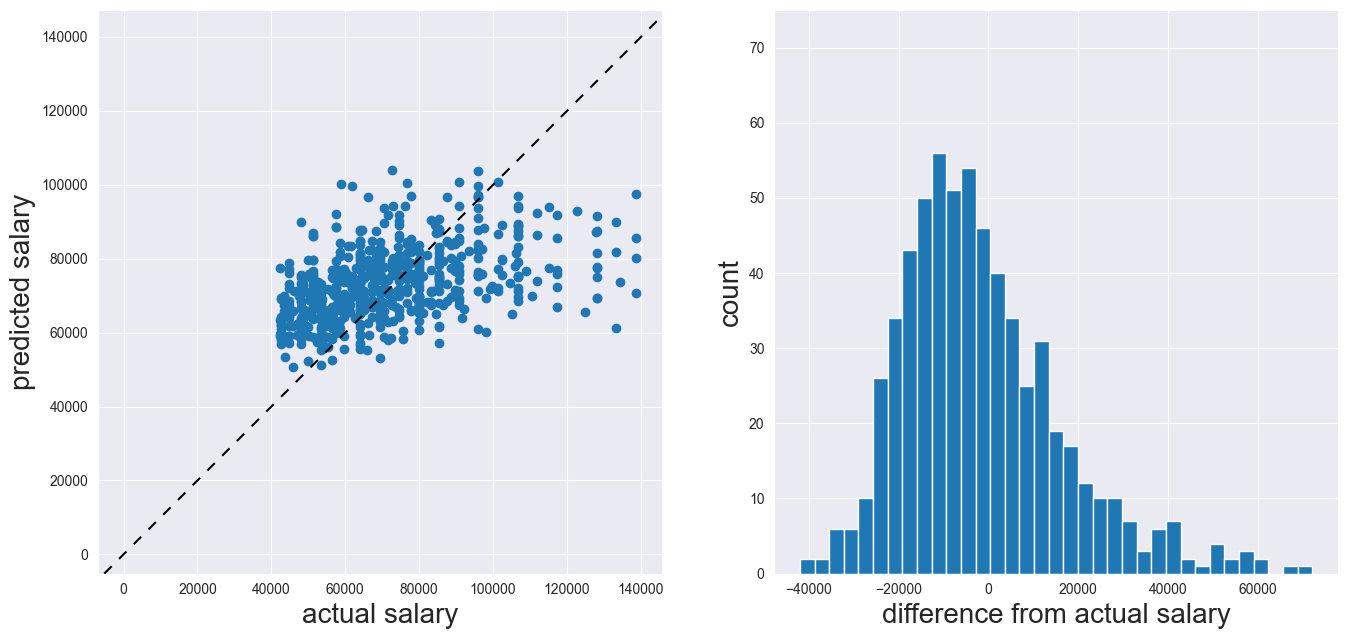

In [5]:
lm = LinearRegression()
lm.fit(x_train, y_train)
prediction_linear = lm.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([lm], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_linear)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_linear), bins=35)
axs[1].set_ylim(ymax=75)

axs[0].set_aspect(np.diff(axs[0].get_xlim())[0] / np.diff(axs[0].get_ylim())[0])
axs[1].set_aspect(np.diff(axs[1].get_xlim())[0] / np.diff(axs[1].get_ylim())[0])

axs[0].xaxis.label.set_size(20)
axs[0].yaxis.label.set_size(20)
axs[1].xaxis.label.set_size(20)
axs[1].yaxis.label.set_size(20)

plt.show()

The linear regression gives already quite good result, but it cannot predict salaries greater than $100,000.

In [6]:
lm_cv = LinearRegression()
estimators = cross_validate(lm_cv, x_train, y_train, cv=folds, return_estimator=True)['estimator']
r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores(estimators, x_test, y_test)
print('R2   (cross validated):', np.round(np.mean(r2_scores), 3))
print('MAE  (cross validated):', np.mean(mae_scores).astype(int))
print('MAPE (cross validated):', np.round(np.mean(mape_scores), 3))
print('RMSE (cross validated):', np.mean(rmse_scores).astype(int))
print('MAX  (cross validated):', np.max(max_scores).astype(int))
print('\nR2   (splits):', np.round(r2_scores, 3))
print('MAE  (splits):', list(map(round, mae_scores)))
print('MAPE (splits):', np.round(mape_scores, 3))
print('RMSE (splits):', list(map(round, rmse_scores)))
print('MAX  (splits):', list(map(round, max_scores)))

R2   (cross validated): 0.193
MAE  (cross validated): 14234
MAPE (cross validated): 0.208
RMSE (cross validated): 18233
MAX  (cross validated): 73437

R2   (splits): [0.194 0.19  0.193 0.19  0.191 0.197 0.194 0.191 0.195 0.193]
MAE  (splits): [14207, 14236, 14219, 14325, 14262, 14140, 14239, 14263, 14220, 14231]
MAPE (splits): [0.207 0.208 0.208 0.21  0.209 0.206 0.208 0.209 0.207 0.208]
RMSE (splits): [18216, 18265, 18230, 18267, 18253, 18191, 18220, 18253, 18206, 18232]
MAX  (splits): [72285, 72345, 71721, 71456, 71457, 73437, 72048, 71543, 72388, 71875]


### Random Forest Regressor

R2:   -0.024
MAE:  15802
MAPE: 0.231
RMSE: 20537
MAX:  71616


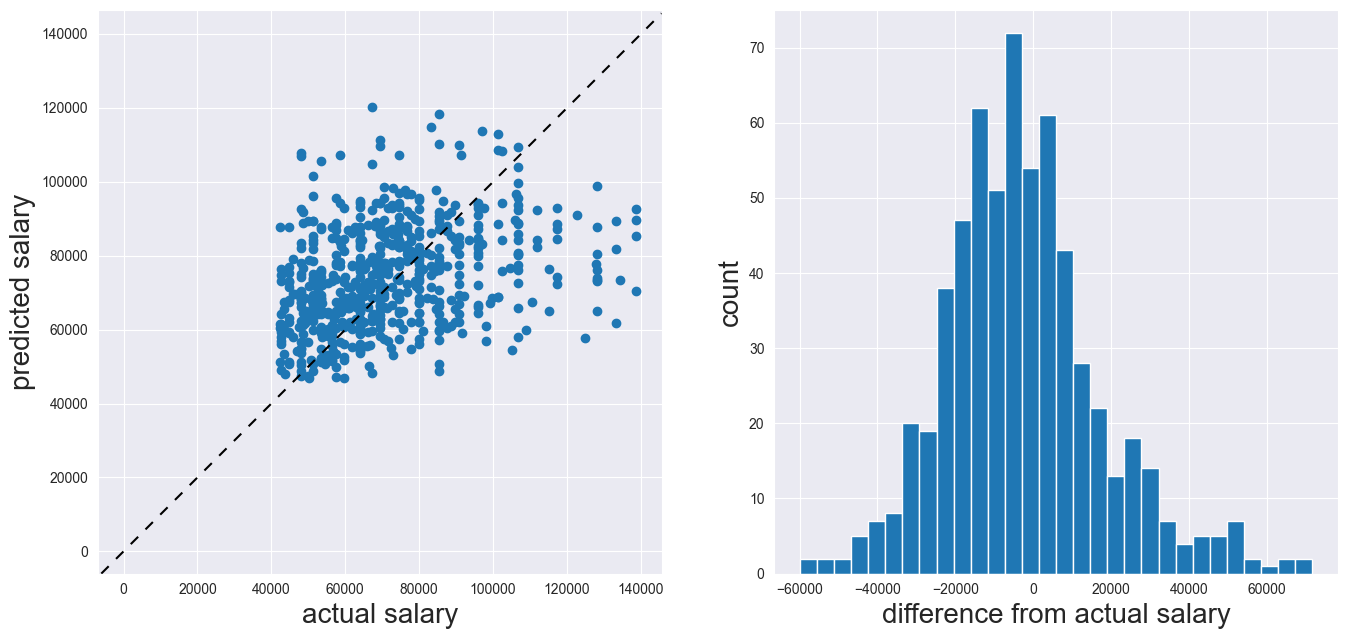

In [7]:
random_regressor = RandomForestRegressor(random_state=1, bootstrap=True)
random_regressor.fit(x_train, y_train)
prediction_rf = random_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([random_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_rf)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_rf), bins=30)
axs[1].set_ylim(ymax=75)

axs[0].set_aspect(np.diff(axs[0].get_xlim())[0] / np.diff(axs[0].get_ylim())[0])
axs[1].set_aspect(np.diff(axs[1].get_xlim())[0] / np.diff(axs[1].get_ylim())[0])

axs[0].xaxis.label.set_size(20)
axs[0].yaxis.label.set_size(20)
axs[1].xaxis.label.set_size(20)
axs[1].yaxis.label.set_size(20)

plt.show()

The random forest regressor is worse than the linear regression. It predicts more salary within a $20,000 range, but it has much more predictions that are more than $40,000 off.

### Gradient Boosting Regressor

R2:   0.169
MAE:  14293
MAPE: 0.209
RMSE: 18500
MAX:  72995


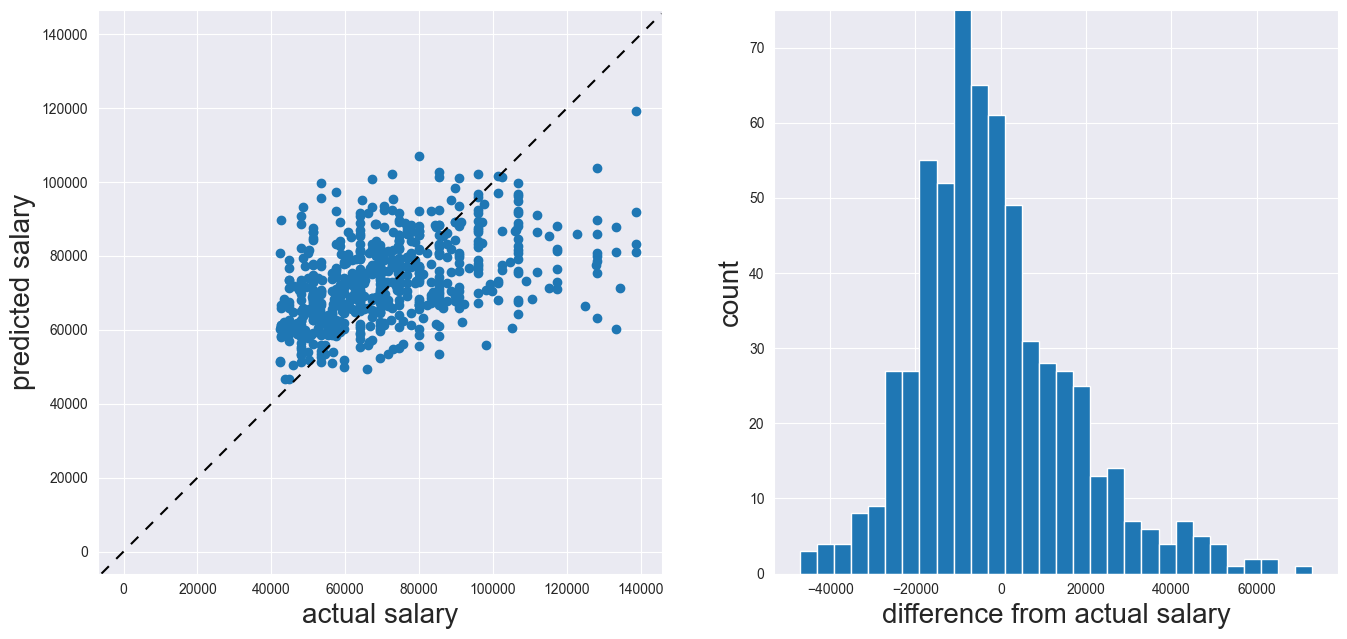

In [8]:
gbt_regressor = GradientBoostingRegressor(random_state=1)
gbt_regressor.fit(x_train, y_train)
prediction_gbt = gbt_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([gbt_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_gbt)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_gbt), bins=30)
axs[1].set_ylim(ymax=75)

axs[0].set_aspect(np.diff(axs[0].get_xlim())[0] / np.diff(axs[0].get_ylim())[0])
axs[1].set_aspect(np.diff(axs[1].get_xlim())[0] / np.diff(axs[1].get_ylim())[0])

axs[0].xaxis.label.set_size(20)
axs[0].yaxis.label.set_size(20)
axs[1].xaxis.label.set_size(20)
axs[1].yaxis.label.set_size(20)

plt.show()

Not much better than the linear regression either. But it also has a better prediction within a difference of $20,000.

## Analyse coefficients

In [9]:
df_coeff = pd.DataFrame()
df_coeff['coeff'] = lm.coef_
df_coeff['feature'] = selected_features
df_coeff['coeff_abs'] = np.abs(lm.coef_)
df_coeff.sort_values(by='coeff_abs', ascending=False)

,coeff,feature,coeff_abs
0,5074.537027,YearsCode,5074.537027
5,5057.780348,Master’s degree,5057.780348
3,3563.920146,Bachelor’s degree,3563.920146
1,3218.917536,OrgSize,3218.917536
2,2606.992778,Age,2606.992778
11,2273.574007,remote,2273.574007
4,1723.494680,Doctoral degree,1723.494680
10,-1714.166593,in-person,1714.166593
9,1303.835595,University courses,1303.835595
7,1115.743677,Professional degree,1115.743677


The results are similar to what we expected and have a similar results as the correlations to the salary.